In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from src.etl.utils import download_data_from_uciml, load_data

In [2]:
download_data_from_uciml(id=544)
X, y = load_data()

In [3]:
print(X.shape, y.shape)

(2111, 16) (2111,)


In [4]:
X.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
dtype: object

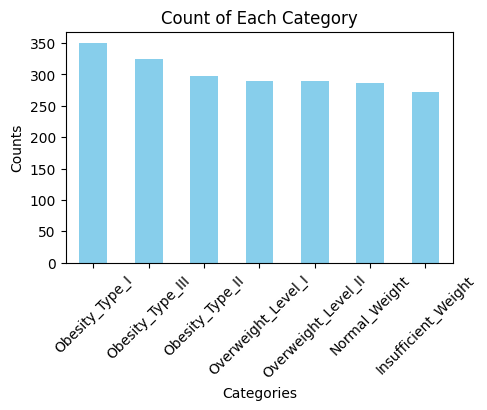

In [5]:
plot_df = y.value_counts()

plt.figure(figsize=(5, 3))
plot_df.plot(kind='bar', color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Count of Each Category')
plt.xticks(rotation=45)
plt.show()

In [12]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import KFold

In [8]:
def preprocess_data(X, y):
    """
    Preprocess the dataset: Encode categorical variables, normalize numerical variables, and convert to PyTorch tensors.

    Parameters:
    df (DataFrame): The dataset
    categorical_features (list): List of categorical feature names
    numeric_features (list): List of numerical feature names
    target_variable (str): Name of the target variable

    Returns:
    X (Tensor): The features as a tensor
    y (Tensor): The target variable as a tensor
    """
    categorical_features = X.select_dtypes(include=['object']).columns
    numeric_features = X.select_dtypes(include=['float64']).columns
    
    y = pd.get_dummies(y).values

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(), categorical_features)])

    X = preprocessor.fit_transform(X)

    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    return X, y

In [19]:
def train_validate_model(model, criterion, optimizer, train_loader, val_loader, epochs: int):
    """
    Train and validate the PyTorch model, returning the history of training and validation losses.

    Parameters:
    model (torch.nn.Module): The model to be trained and validated
    criterion (Callable): Loss function
    optimizer (torch.optim.Optimizer): Optimizer
    train_loader (DataLoader): DataLoader for the training set
    val_loader (DataLoader): DataLoader for the validation set
    epochs (int): Number of training epochs

    Returns:
    Tuple[List[float], List[float]]: Lists of average training and validation losses per epoch
    """
    train_losses, val_losses = [], []

    for epoch in tqdm(range(epochs)):
        model.train()
        total_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, torch.max(labels, 1)[1])
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

    return train_losses, val_losses


def evaluate_model(model, test_loader):
    """
    Evaluate the PyTorch model.

    Parameters:
    model: The PyTorch model to be evaluated
    test_loader: DataLoader for the test set

    Returns:
    accuracy (float): The accuracy of the model on the test set
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == torch.max(labels, 1)[1]).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [24]:
from typing import Callable, List

def perform_cross_validation(model_factory: Callable[[int, int], torch.nn.Module], 
                             X: torch.Tensor, 
                             y: torch.Tensor, 
                             k_folds: int,
                             epochs: int = 10) -> List[float]:
    """
    Perform k-fold cross-validation and return average test accuracy, training losses, and validation losses.

    Parameters:
    model_factory (Callable[[int, int], torch.nn.Module]): Factory function to create a new instance of the model
    X (torch.Tensor): The features
    y (torch.Tensor): The target variable
    k_folds (int): Number of folds in cross-validation

    Returns:
    Tuple[float, List[List[float]], List[List[float]]]: Average accuracy, training losses, validation losses
    """
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_accuracies = []
    all_train_losses, all_val_losses = [], []

    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)):
        # Split data for the fold
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = y[train_ids], y[test_ids]

        # DataLoaders
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)
        test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)
        
        # Determine input and output sizes
        input_size = X_train.shape[1]
        output_size = y_train.shape[1] # assuming y_train is one-hot encoded

        # Initialize model for the current fold
        model = model_factory(input_size, output_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train and Evaluate the model        
        train_losses, val_losses = train_validate_model(model, criterion, optimizer, train_loader, val_loader, epochs)
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        fold_accuracy = evaluate_model(model, test_loader)
        print(f'Fold {fold+1}, Accuracy: {fold_accuracy}%')
        fold_accuracies.append(fold_accuracy)
        
    avg_accuracy = np.mean(fold_accuracies)
    return avg_accuracy, all_train_losses, all_val_losses

In [25]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)
        return x

In [26]:
def plot_train_val_losses(train_losses, val_losses):
    """
    Plot the training and validation loss curves.

    Parameters:
    train_losses (List[List[float]]): Training losses for each fold
    val_losses (List[List[float]]): Validation losses for each fold
    """
    avg_train_losses = np.mean(train_losses, axis=0)
    avg_val_losses = np.mean(val_losses, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(avg_train_losses, label='Average Training Loss')
    plt.plot(avg_val_losses, label='Average Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 42.21it/s]


Fold 1, Accuracy: 96.6903073286052%


100%|██████████| 50/50 [00:01<00:00, 43.27it/s]


Fold 2, Accuracy: 95.97156398104265%


100%|██████████| 50/50 [00:01<00:00, 42.56it/s]


Fold 3, Accuracy: 96.2085308056872%


100%|██████████| 50/50 [00:01<00:00, 42.51it/s]


Fold 4, Accuracy: 95.97156398104265%


100%|██████████| 50/50 [00:01<00:00, 43.53it/s]

Fold 5, Accuracy: 99.0521327014218%


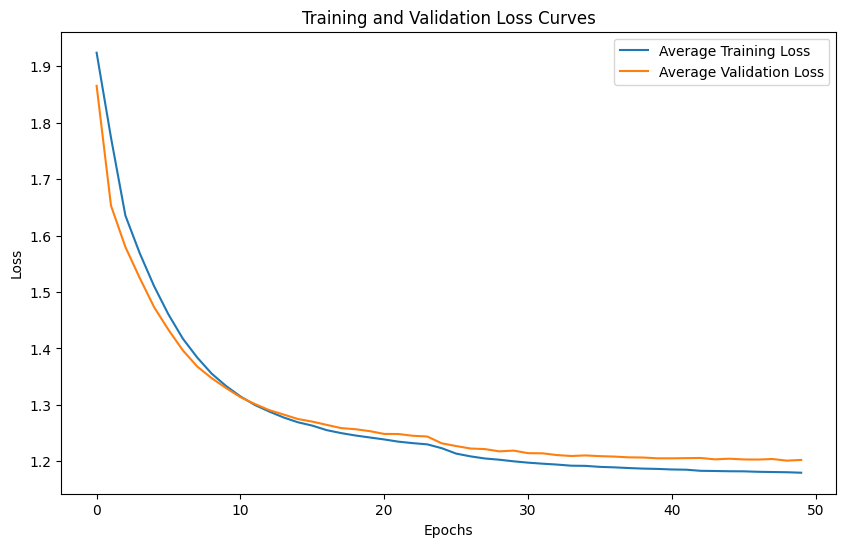

Average Cross-Validation Accuracy: 96.78%


In [30]:
X_preprocessed, y_preprocessed = preprocess_data(X, y)

avg_accuracy, all_train_losses, all_val_losses = perform_cross_validation(
    lambda input_size, output_size: Net(input_size, output_size),
    X_preprocessed, y_preprocessed, k_folds=5, epochs=50
)

plot_train_val_losses(all_train_losses, all_val_losses)

print(f'Average Cross-Validation Accuracy: {round(avg_accuracy, 2)}%')